## Election Forecast 2020

I used the 538 data for states, with the intention of 1) making a prediction, and 2) show how state polls, when aggregated, approximate the national percentage. Do we need national election data? The model I estimate is fairly simple. Here is the design. 

$y_{j,s}$ corresponds to the $j$th poll conducted in the $s$ state. It is a percentage. So, the first thing I did was truncate the data to only include observations since September 1. I also model two party vote. I calculated this below in the tibble call. 

The model I estimate is simple: it is a Bayesian linear regression with random effects on state -- every state has multiple surveys since September. I draw the mean of each state from a non-informative normal distribution (the prior variance is quite large).  Below I used the **brms** package.

Finally, I use the posterior estimates to calculate the percentage of voters within each state who vote Trump versus Biden. As a final step, I use the median of the posterior to simulate what happens to the electoral college, if we were to simulate the election 100,000 times, a truly frequentist method.

Here's the data -- I downloaded 538 data for state level polls.


In [182]:
library(dplyr)
data=read.csv("~/desktop/Simulation/president_polls.csv") %>% filter(state!="") %>%
            filter((candidate_name=="Joseph R. Biden Jr.") | (candidate_name=="Donald Trump")) %>%
            group_by(question_id) %>%
            mutate(denom=sum(pct))%>%
            mutate(two_party=pct/denom) %>%
            ungroup()             
fips=read.csv(
    url("https://gist.githubusercontent.com/dantonnoriega/bf1acd2290e15b91e6710b6fd3be0a53/raw/11d15233327c8080c9646c7e1f23052659db251d/us-state-ansi-fips.csv")
)
ev=read.csv(
    url("https://raw.githubusercontent.com/pkremp/polls/master/2012.csv")
)[1:50,8]

ev2=read.csv(
    url("https://raw.githubusercontent.com/pkremp/polls/master/2012.csv")
)
names(fips)<-c("stname", "st", "fips")
data$stname<-as.character(data$state)
fips$stname<-as.character(fips$stname)
dat=merge(data, fips, by="stname", all.x=T) 
dat=subset(dat, candidate_name=="Donald Trump") 
dat=subset(dat, state!=c("District of Columbia"))
dat=subset(dat, state!=c("Maine CD-1"))
dat=subset(dat, state!=c("Maine CD-2"))
dat=subset(dat, state!=c("Nebraska CD-2"))
dat$state<-as.factor(dat$stname)

## Prediction using BRMS

Let's use the BRMS package to estimate this model. There are no covariates. There is simply a random effect for each state (recall there are multiple state level observations). The model is called **simple_model**, the priors are **prior1** and the data are **dat** from above. The model does take a minute or two to run.

In [183]:
library(brms)
simple_model <- bf(pct ~ 1 + (1 | stname))
prior1 <- 
  prior("normal(0, 3)", class = "sd", group = "stname") 
m1 <- brm(
  formula = simple_model,
  data = dat,
  family=gaussian(),
  prior=prior1,
  seed=1234,
  iter=50000,
  cores=8)



Compiling Stan program...
Start sampling


In [184]:
m1

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: pct ~ 1 + (1 | stname) 
   Data: dat (Number of observations: 2293) 
Samples: 4 chains, each with iter = 50000; warmup = 25000; thin = 1;
         total post-warmup samples = 1e+05

Group-Level Effects: 
~stname (Number of levels: 50) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     8.91      0.79     7.52    10.57 1.01     1103     1922

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept    46.50      1.29    43.90    48.99 1.01      734     1168

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     1.92      0.03     1.87     1.98 1.00    10056    20529

Samples were drawn using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

## Overall prediction, from state polling

The model estimates a single intercept, of about 45-46%. This could be viewed as the average vote preference. It mirrors, almost exactly, the current national polling average on 538.

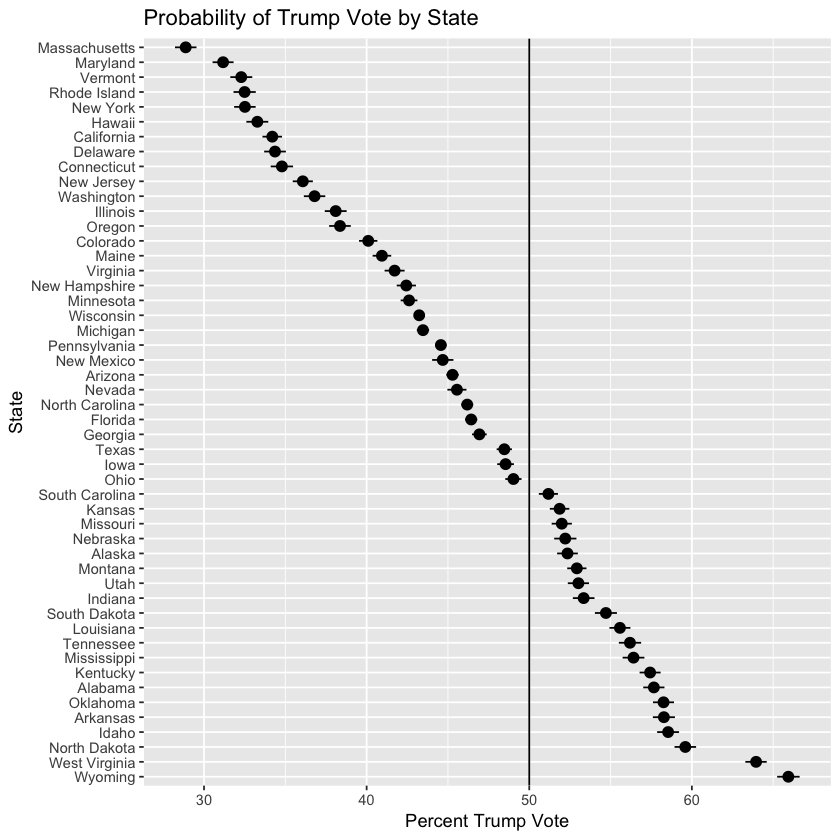

In [186]:
library(ggplot2)
State=names(table(dat$stname))
state= unlist(coef(m1)) %>% matrix(ncol=4) %>% data.frame %>% mutate(State=State)
ggplot(state, aes(reorder(State, -X1), X1, ymin = X3, ymax = X4)) +
  geom_pointrange() +
  coord_flip() +
  labs(x = "State", y="Percent Trump Vote", title="Probability of Trump Vote by State")+ 
  geom_hline(yintercept=50)
    





For good measure, let's predict the outcome for each state

In [187]:
names(state)[1:4]<-c("Prediction", "SE", "Min", "Max")
state

Prediction,SE,Min,Max,State
57.66231,0.3340890,57.00787,58.31388,Alabama
52.34960,0.3245190,51.71220,52.98795,Alaska
45.28111,0.1950200,44.89809,45.66130,Arizona
58.27875,0.3453668,57.60044,58.95663,Arkansas
34.19791,0.3066306,33.59365,34.79673,California
40.09804,0.2886923,39.53126,40.66203,Colorado
34.78865,0.3503918,34.10073,35.47653,Connecticut
34.36440,0.3410143,33.69836,35.03324,Delaware
46.42776,0.1945827,46.04607,46.80905,Florida
46.93275,0.2306526,46.48091,47.38408,Georgia


Now, let's take things a bit further. Let's use the posterior draws to simulate what happens in terms of the electoral college. Here's how I'll set that up.

In [190]:
## Initialize a vector to store results on 1 trial
temp1=c()
temp2=c()

ev.vote=function(){
            for(i in 1:50){
                temp1=rbind(temp1,
                rbinom(1,1, state$Prediction[i]/100)*ev[i])
        }
    return(temp1[-1])
}    

for(i in 1:100000){
    temp2=rbind(temp2,
                sum(ev.vote())
                )
    }

In [191]:
#### In 100000 simulations 
table(temp2[-1]>270)/sum(table(temp2>270))




  FALSE    TRUE 
0.78495 0.21504 

In these 100,000 trials weighting by electoral votes, Biden wins around 75% of the time, Trump wins 25%.